In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date



symbols  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]

all_stocks = pd.DataFrame()
 
for symbol in symbols:
    tmp_close = yf.download(symbol, 
                      start='2020-01-01', 
                      end= date.today(),
                      interval = "1d",
                      threads = True,
                      progress=False)['Adj Close']
    all_stocks = pd.concat([all_stocks, tmp_close], axis=1)
 
all_stocks.columns=symbols
all_stocks

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2019-12-31,311.803253,210.392792,55.027191,59.418938,57.360989,43.318329,37.135902,86.537415,35.788086,109.723869,107.936653,131.112869,28.201138,15.950000,142.899994,32.049999,56.491619,55.706581,36.390457,7.195854
2020-01-02,314.719147,213.905792,55.487320,59.953213,57.961323,44.196861,37.169262,85.520851,35.861885,110.260376,108.436081,132.593552,28.171780,15.970000,143.949997,32.299999,57.426060,57.566662,36.906452,7.414512
2020-01-03,312.336029,211.946411,54.792435,59.199505,57.322258,43.376259,37.169262,86.052444,35.788086,110.768677,109.160736,134.635544,28.181564,16.160000,145.860001,31.520000,56.727589,55.668228,36.703434,7.275366
2020-01-06,313.527649,213.312027,54.999020,59.237675,57.525597,43.270058,37.227642,86.155037,35.871117,110.486290,109.043205,133.871002,28.230511,16.190001,147.389999,31.639999,56.567127,55.025829,36.999500,7.076585
2020-01-07,312.646027,213.282364,54.726704,59.094559,57.622421,43.241096,37.319374,85.194450,35.741951,110.147423,108.886520,133.213013,28.142410,16.180000,147.970001,32.540001,55.623245,55.917519,36.999500,7.086524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,437.750000,345.769989,63.840000,67.160004,63.549999,47.349998,31.830000,104.089996,33.709999,124.784912,110.760139,136.688965,27.168009,23.469999,176.550003,35.290001,47.709999,111.230003,53.570000,17.660000
2022-02-28,436.630005,346.799988,62.320000,66.610001,62.939999,46.730000,31.780001,102.540001,33.470001,126.951004,112.019005,139.684998,27.177999,23.870001,178.380005,35.549999,47.700001,107.010002,54.029999,18.860001
2022-03-01,429.980011,341.489990,60.669998,65.209999,62.080002,46.110001,31.490000,102.000000,32.959999,127.860001,113.110001,141.300003,27.190001,24.830000,181.619995,35.560001,46.820000,108.050003,53.110001,18.320000
2022-03-02,437.890015,347.220001,61.610001,66.059998,62.290001,46.189999,32.080002,103.910004,33.430000,127.029999,111.410004,136.470001,26.920000,25.639999,179.729996,34.619999,48.869999,109.610001,53.660000,18.530001


In [2]:
returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns = returns.iloc[1: , :]
returns.iloc[0:253 , :]

,SPY,QQQ,VGK,SCZ,EWJ,EEM,REM,VNQ,RWX,TIP,IEF,TLT,BWX,DBC,GLD,twtr,intc,tsm,VWUSX,Amc
2020-01-02,0.009308,0.016559,0.008327,0.008951,0.010412,0.020078,0.000898,-0.011817,0.002060,0.004878,0.004616,0.011230,-0.001042,0.001253,0.007321,0.007770,0.016406,0.032845,0.014080,0.029934
2020-01-03,-0.007601,-0.009202,-0.012602,-0.012651,-0.011087,-0.018742,0.000000,0.006197,-0.002060,0.004599,0.006661,0.015283,0.000347,0.011827,0.013181,-0.024445,-0.012238,-0.033534,-0.005516,-0.018945
2020-01-06,0.003808,0.006423,0.003763,0.000645,0.003541,-0.002451,0.001569,0.001191,0.002317,-0.002553,-0.001077,-0.005695,0.001735,0.001855,0.010435,0.003800,-0.002833,-0.011607,0.008034,-0.027703
2020-01-07,-0.002816,-0.000139,-0.004964,-0.002419,0.001682,-0.000670,0.002461,-0.011212,-0.003607,-0.003072,-0.001438,-0.004927,-0.003126,-0.000618,0.003927,0.028048,-0.016827,0.016075,0.000000,0.001404
2020-01-08,0.005315,0.007488,0.002570,-0.000323,0.000168,0.005788,-0.002909,0.003060,-0.007254,-0.000940,-0.002341,-0.006633,-0.003135,-0.014944,-0.007530,0.015551,0.000679,0.007346,0.008650,-0.074216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003883,0.004403,0.002495,0.004881,-0.003640,-0.004379,-0.004414,0.008717,0.002380,0.000393,0.001420,0.003949,0.001934,0.002743,0.003977,-0.006096,0.010679,0.021075,0.001820,-0.019724
2020-12-28,0.008554,0.010028,0.006789,0.004269,0.010128,0.002789,0.006927,0.005943,0.006221,0.000707,0.000084,0.000445,-0.000322,-0.006183,-0.003636,0.008487,0.000000,0.001697,-0.004404,-0.048989
2020-12-29,-0.001910,0.000895,0.007235,0.008193,0.012406,0.014809,-0.012630,-0.008569,0.008528,-0.000471,-0.000167,-0.001272,0.003216,0.002753,0.003636,-0.001287,0.048112,-0.005574,-0.001523,-0.042742
2020-12-30,0.001426,0.000032,-0.001311,0.001937,0.000445,0.013240,0.006335,0.005483,0.004674,0.000785,0.000668,0.002161,0.005125,0.006167,0.007626,-0.000552,-0.013043,0.031151,0.002436,-0.058444


Prix des actions à l'instant t-1

In [3]:
vp = all_stocks[-1::].values[0]
vp

array([435.70999146, 342.26000977,  59.84000015,  64.75      ,
        61.97999954,  45.54000092,  31.92000008, 104.76000214,
        33.04999924, 126.87999725, 111.88999939, 137.86000061,
        26.95000076,  25.92000008, 180.80000305,  33.49000168,
        47.93000031, 108.79000092,  52.31999969,  18.05999947])

In [39]:
from scipy.optimize import minimize, Bounds

# ----------------------------- initialisation des variables --------------------------------------------

# Paramètres modifiables

lamb = 0.01 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 100 # importance accordée à l'expected return
Money = 1000 # argent alloué pour l'investissement initial
Pos_max_par_actif = 1000 # quantité maximale d'argent investi par actif

# Variables utilisées dans l'algorithme

argent_gagne = 0
s = 0
Pos = []
nb_actifs = returns.shape[1]
argent_fait = []

# pos = portefeuille initialement vide
pos = np.array([0 for i in range(nb_actifs)])


# -------------------- fonction objectif et coûts de transaction -------------------------------------

def objective_corr(pos):
    global s
    
    s = pos@correl_matrix@pos - alpha*expected_returns@pos
    
    # print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    # print('\033[93m'+"Return : " + str(returns.mean()@pos) + '\033[0m')
    # print('\033[94m'+"Somme des positions: "+str(vp@pos.T)+'\033[0m')
    # print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    # print(f"Les valeurs de la fonction objectif:{s.round(3)}")
    return s

def TC(Pos,pos):
    return lamb*(np.sum(np.abs(pos-Pos[-1])))

 
# Every stock can get any position from 0 to Pos_max_par_actif
bounds = Bounds(0, Pos_max_par_actif)


# ----------------  calcul du portefeuille initial avec l'argent à investir ---------------------------------

# "ineq" says that the inequality must be non-negative.

cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
        # The positions must invest no more than the initial money.
        {"type": "ineq", "fun": lambda x: -(TC(Pos,x)+ np.sum(x)) + Money},
        # the transactions costs must be covered by the money invested
        
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
       )

# we compare any asset allocation to the empty portfolio
Pos.append(pos) 

# import des données roulantes
log_returns = returns.iloc[0:253 , :]
# calcul des expected returns (on prend une période plus courte)
expected_returns = log_returns.iloc[-15:: ,:].mean()

# calcul de la matrice de corrélation
correl = log_returns.cov().copy()
correl_matrix = correl.to_numpy()

# calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
vp = all_stocks[253::].values[0]
vp2 = all_stocks[254::].values[0]

# calcul du vecteur position
p = minimize(objective_corr, pos, 
         method = "SLSQP", 
         bounds= bounds,
         constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})

pos = p.x # les positions prises en fin de journée

# affichage des valeurs numériques
print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
print('\033[94m'+"Somme des positions: "+str(np.sum(pos))+'\033[0m')
print(f"Les valeurs  du vecteur poids sont :{pos.round(3)}")
print(f"La valeur de la fonction objectif est :{s.round(3)}")

# mise à jour du vecteur des positions à chaque actualisation des prix
pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
Money = np.sum(pos2) # l'argent dont on dispose dans le portefeuille
argent_fait.append(Money)
argent_gagne += np.sum(pos2-pos) # sans compter les côuts de transaction, les bénéfices 
# réalisés par l'augmentation des valeurs des actifs
print('\033[95m'+"Argent généré sans TC : "+str(argent_gagne)+'\033[0m')
pos = pos2
print('\033[94m'+"Somme des positions: "+str(Money)+'\033[0m')


# ------------------------------ calcul de l'optimisation roulante -------------------------------------------

for i in range(1,100):
    global correl_matrix, vp, Money, pos, argent_gagne, expected_returns
    
    print(Money)
    # actualisation des contraintes
    cons = ({"type":"ineq", "fun": lambda x: Money - np.sum(np.array(x)) }, 
        # The positions must invest no more than the initial money.
        # This constraints says that the inequalities (ineq) must be non-negative.
        {"type": "ineq", "fun": lambda x: -(TC(Pos,x) + np.sum((x-Pos[-1])))},
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        #{"type": "ineq", "fun": lambda x: -np.sum(returns.mean()*x)+1})
       )
    
    # actualisation des positions
    Pos.append(pos)
    
    # import des données roulantes
    log_returns = returns.iloc[i:253+i , :]
    #print(log_returns.mean())
    #print(returns.iloc[254+i , :])
# calcul des expected returns (on prend une période plus courte)
expected_returns = log_returns.iloc[-15:: ,:].mean()
    
    
    # calcul de la matrice de corrélation
    correl = log_returns.cov().copy()
    correl_matrix = correl.to_numpy()
    
    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+i::].values[0]
    vp2 = all_stocks[254+i::].values[0]
    
    # calcul du vecteur position
    p = minimize(objective_corr, Pos[-1], 
             method = "SLSQP", 
             bounds= bounds,
             constraints= cons, options={'maxiter': 300, 'ftol': 1e-09})
    
    pos = p.x # les positions prises en fin de journée
    
    # affichage des valeurs numériques
    print('\033[92m'+"Coûts de transaction: "+str(TC(Pos,pos))+'\033[0m')
    print('\033[93m'+"Return : " + str(log_returns.mean()@pos) + '\033[0m')
    print('\033[94m'+"Somme des positions: "+str(np.sum(pos))+'\033[0m')
    print(f"Les valeurs  du vecteur poids sont:{pos.round(3)}")
    print(f"Les valeurs de la fonction objectif:{s.round(3)}")

    # mise à jour du vecteur des positions à chaque actualisation des prix
    pos2 = np.array([pos[i]*vp2[i]/vp[i] for i in range(nb_actifs)])
    Money = np.sum(pos2)
    argent_fait.append(Money)
    argent_gagne += np.sum(pos2-pos)
    print('\033[95m'+"Argent généré sans TC : "+str(argent_gagne)+'\033[0m')
    pos = pos2
    print('\033[94m'+"Somme des positions: "+str(Money)+'\033[0m')
    
print("\n","fin du calcul")

Coûts de transaction: 9.900990099009885
Return : 0.8274642515670529
Somme des positions: 990.0990099009884
Les valeurs  du vecteur poids sont :[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    688.822  23.444   0.      0.     57.771   0.      0.    130.682
  89.381   0.   ]
La valeur de la fonction objectif est :-54.082
Argent généré sans TC : 3.174442713733862
Somme des positions: 993.2734526147224
993.2734526147224
Coûts de transaction: 1.0657050703318098
Return : 0.8015520550941855
Somme des positions: 992.2077475443955
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    697.499   0.      0.      0.     92.674   7.171   0.    137.329
  57.535   0.   ]
Les valeurs de la fonction objectif:-52.242
Argent généré sans TC : 3.6213963559459508
Somme des positions: 992.6547011866074
992.6547011866074
Coûts de transaction: 0.2738873299068623
Return : 0.8243041141439511
Somme des positions: 992.38081385

Coûts de transaction: 0.6255874564265816
Return : 0.9396832009694849
Somme des positions: 991.36413256064
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    757.925   0.      0.      0.      0.      0.      0.    208.356
  11.34   13.744]
Les valeurs de la fonction objectif:-55.512
Argent généré sans TC : 6.131403804629186
Somme des positions: 988.7668524158304
988.7668524158304
Coûts de transaction: 0.26348223601671905
Return : 0.8965323226050941
Somme des positions: 988.5033701798142
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    755.579   0.      0.      0.      0.      0.      0.    205.939
  24.54    2.445]
Les valeurs de la fonction objectif:-52.978
Argent généré sans TC : -1.3817166663041434
Somme des positions: 980.9902497088808
980.9902497088808
Coûts de transaction: 0.08623566854888079
Return : 0.8350956737791057
Somme des positions: 980.9040140403

Coûts de transaction: 0.23208235466057342
Return : 0.9037884127703556
Somme des positions: 975.4773157025967
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    728.427   0.      0.      0.      0.     26.781   0.    218.79
   0.      1.479]
Les valeurs de la fonction objectif:-47.081
Argent généré sans TC : 1.0108423745079937
Somme des positions: 979.7089157178461
979.7089157178461
Coûts de transaction: 0.20822227090250456
Return : 0.9762765581182524
Somme des positions: 979.5006934469442
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.    716.911   0.      0.      0.      0.     29.54    0.    229.616
   0.      3.433]
Les valeurs de la fonction objectif:-49.775
Argent généré sans TC : -18.68506350370054
Somme des positions: 959.8047875687357
959.8047875687357
Coûts de transaction: 2.3728787700906717
Return : 0.8272696503761637
Somme des positions: 763.558388620

Coûts de transaction: 0.9049574128319943
Return : 1.1104945630395446
Somme des positions: 347.03036019863544
Les valeurs  du vecteur poids sont:[  0.      0.      0.    136.926   0.      0.      0.      0.      0.
   0.      0.      0.      0.     10.857   0.     62.847   0.    122.057
   0.     14.344]
Les valeurs de la fonction objectif:-70.569
Argent généré sans TC : -38.33663124950622
Somme des positions: 346.60053813834475
346.60053813834475
Coûts de transaction: 0.39767780031914063
Return : 1.2431797065541228
Somme des positions: 346.20286033802495
Les valeurs  du vecteur poids sont:[  0.      0.      0.    129.414   0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.     72.45    0.    130.75
   0.     13.589]
Les valeurs de la fonction objectif:-83.766
Argent généré sans TC : -36.71904262374399
Somme des positions: 347.8204489637871
347.8204489637871
Coûts de transaction: 0.3466727480404829
Return : 1.1977665261100268
Somme des positions: 347.473776

Coûts de transaction: 1.235952683953886
Return : 1.1644619189291325
Somme des positions: 347.60210983133527
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.     30.327   0.      0.
   0.      0.      0.      0.     35.637   0.     79.773   0.    171.744
  17.634  12.487]
Les valeurs de la fonction objectif:-74.589
Argent généré sans TC : -29.23527191783868
Somme des positions: 345.23641279857543
345.23641279857543
Coûts de transaction: 0.34433224539934615
Return : 1.1617606948894044
Somme des positions: 344.8920805531761
Les valeurs  du vecteur poids sont:[  0.      0.      0.      6.216   0.      0.     31.419   0.      0.
   0.      0.      0.      0.     41.489   0.     78.64    0.    171.802
   0.     15.326]
Les valeurs de la fonction objectif:-74.76
Argent généré sans TC : -29.31623675943648
Somme des positions: 344.8111157115783
344.8111157115783
Coûts de transaction: 0.4722903995384819
Return : 1.096190003571502
Somme des positions: 344.338825312

Coûts de transaction: 0.19346597160848317
Return : 0.86327258404975
Somme des positions: 331.3802382235308
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.     34.985   0.      0.
   0.      0.      0.      0.    159.172   0.     16.19    0.    113.789
   0.      7.244]
Les valeurs de la fonction objectif:-67.844
Argent généré sans TC : -41.64922634992096
Somme des positions: 325.0614289267053
325.0614289267053
Coûts de transaction: 0.2692107027786586
Return : 0.8012908510391247
Somme des positions: 324.79221822392657
Les valeurs  du vecteur poids sont:[  0.      0.      0.      0.      0.      0.     34.593   0.      0.
   0.      0.      0.      0.    171.394   0.      6.328   0.    105.184
   0.      7.292]
Les valeurs de la fonction objectif:-63.25
Argent généré sans TC : -39.3954372685521
Somme des positions: 327.0460073052954
327.0460073052954
Coûts de transaction: 0.26775288043726797
Return : 0.7901669953252582
Somme des positions: 326.77825442485

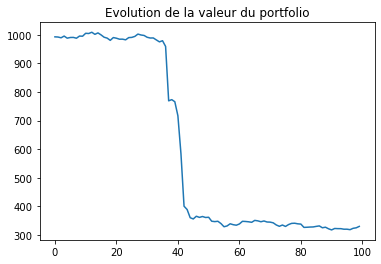

In [40]:
plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

In [34]:
Pos[-1].round(3)

array([  0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,  65.254,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   , 109.269,
         0.   ,   2.807,   0.   , 135.474,   0.   ,  12.098])

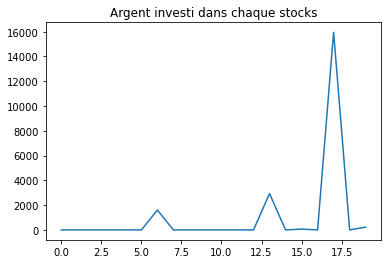

L'argent est le plus investi dans l'action: tsm


In [35]:
plt.plot([p.x[i] * all_stocks[-1::].values[0][i] for i in range(len(p.x))])
plt.title("Argent investi dans chaque stocks")
plt.show()
print("L'argent est le plus investi dans l'action: "+symbols[np.argmax([p.x[i] * all_stocks[-1::].values[0][i] for i in range(len(p.x))])])

In [27]:
# On a bien investi au plus Money=1000
np.dot(vp,p.x.T)

119364.53476572574

In [8]:
# Le returns avec une telle repartition de portefeuille est de:
np.sum(returns.mean()*p.x)

-0.001638022739661512

In [9]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([symbols,p.x])
for i in range(len(symbols)):
    print(symbols[i],p.x[i].round(3))

Nombre d'action acheté pour chaque symbols: 
SPY -0.0
QQQ -0.0
VGK -0.0
SCZ -0.0
EWJ -0.0
EEM -0.0
REM -0.0
VNQ -0.0
RWX -0.0
TIP -0.0
IEF -0.0
TLT -0.0
BWX -0.0
DBC -0.0
GLD -0.0
twtr 0.0
intc -0.0
tsm 3.176
VWUSX 0.0
Amc -3.284
